In [97]:
# Importación de librerías.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
# Importación de la base de datos y uso del formato óptimo.
df = pd.read_csv('/content/drive/MyDrive/Diplomado en ciencia de datos/Redes neuronales profundas/Café.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values('datetime')

df.sample(10)

,date,datetime,cash_type,card,money,coffee_name
1276,2024-08-14,2024-08-14 18:10:03.723,card,ANON-0000-0000-0505,23.02,Cortado
2261,2024-11-09,2024-11-09 14:21:51.604,card,ANON-0000-0000-0874,35.76,Hot Chocolate
2943,2025-02-04,2025-02-04 14:19:48.544,card,ANON-0000-0000-1171,25.96,Americano
1631,2024-09-22,2024-09-22 10:13:08.586,card,ANON-0000-0000-0649,32.82,Latte
903,2024-07-02,2024-07-02 16:31:24.337,card,ANON-0000-0000-0341,32.82,Americano with Milk
446,2024-05-11,2024-05-11 11:39:52.878,card,ANON-0000-0000-0069,37.72,Latte
1743,2024-09-30,2024-09-30 19:53:14.092,card,ANON-0000-0000-0694,30.86,Americano with Milk
2864,2025-01-28,2025-01-28 16:19:07.605,card,ANON-0000-0000-1134,35.76,Cocoa
656,2024-05-31,2024-05-31 09:21:07.821,card,ANON-0000-0000-0246,37.72,Latte
2266,2024-11-09,2024-11-09 16:16:52.424,card,ANON-0000-0000-0570,35.76,Cocoa


In [99]:
# Descripción de datos.
print(df.info())
print("\n\n", df.describe)
print("\n\n", df.isna().sum())
print("\n\n", df.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3636 non-null   object        
 1   datetime     3636 non-null   datetime64[ns]
 2   cash_type    3636 non-null   object        
 3   card         3547 non-null   object        
 4   money        3636 non-null   float64       
 5   coffee_name  3636 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 170.6+ KB
None


 <bound method NDFrame.describe of             date                datetime cash_type                 card  \
0     2024-03-01 2024-03-01 10:15:50.520      card  ANON-0000-0000-0001   
1     2024-03-01 2024-03-01 12:19:22.539      card  ANON-0000-0000-0002   
2     2024-03-01 2024-03-01 12:20:18.089      card  ANON-0000-0000-0002   
3     2024-03-01 2024-03-01 13:46:33.006      card  ANON-0000-0000-0003   
4     2024-0

In [100]:
# Seleccionamos las variables de interés.
df = df[['datetime', 'money']].dropna()

df = df.set_index('datetime').resample('H').mean().fillna(method='ffill')

<ipython-input-100-7dba81d8bdf5>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('datetime').resample('H').mean().fillna(method='ffill')
<ipython-input-100-7dba81d8bdf5>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.set_index('datetime').resample('H').mean().fillna(method='ffill')


In [101]:
# Escalamos los datos.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['money']])

In [102]:
# Creamos secuencias para el modelo LSTM.
def create_dataset(data, look_back=72):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 72
X, y = create_dataset(scaled_data, look_back)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape((X_train.shape[0], look_back, 1))
X_test = X_test.reshape((X_test.shape[0], look_back, 1))

In [103]:
# Definimos el modelo LSTM.
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [104]:
# Summary del modelo.
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 72, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 72, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

In [105]:
# Entrenamos el modelo.
model.fit(X_train, y_train, epochs=50, batch_size=48, verbose=1)

Epoch 1/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0671
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0246
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0209
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0192
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0179
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0174
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0163
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0156
Epoch 9/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0161
Epoch 10/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0150
Epoch 11/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0149
Epoch 12/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0147
Epoch 13/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0148
Epoch 14/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0146
Epoch 15/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step 

In [107]:
# Hacemos predicciones.
predictions = model.predict(X_test)

predictions_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [108]:
# Métricas.
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions_inv))
r2 = r2_score(y_test_inv, predictions_inv)
print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.4f}')

RMSE: 2.71
R² Score: 0.5586


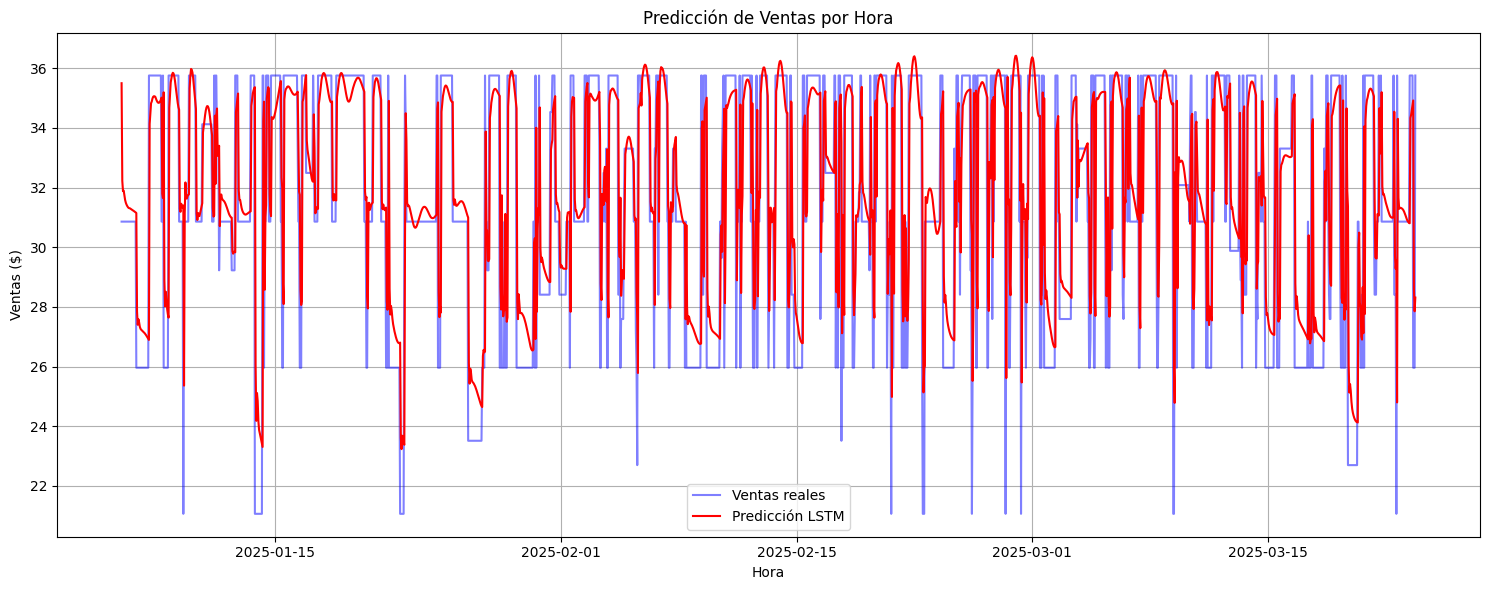

In [109]:
#Graficamos.
fechas_test = df.index[-len(y_test):]

plt.figure(figsize=(15,6))
plt.plot(fechas_test, y_test_inv, label='Ventas reales', color='blue', alpha=0.5)
plt.plot(fechas_test, predictions_inv, label='Predicción LSTM', color='red')
plt.title('Predicción de Ventas por Hora')
plt.xlabel('Hora')
plt.ylabel('Ventas ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🕒 Horarios con mayores ventas promedio (según predicción):
hour
23    32.759212
22    32.758667
0     32.738564
21    32.716179
1     32.698799
2     32.637474
3     32.560852
20    32.509079
4     32.471493
19    32.422455
5     32.375923
6     32.282921
7     32.105049
17    31.999039
8     31.922474
16    31.770561
18    31.728680
15    31.489470
9     31.233826
10    31.192387
14    31.168518
13    31.089983
11    30.840767
12    30.740450
Name: predicted_sales, dtype: float32


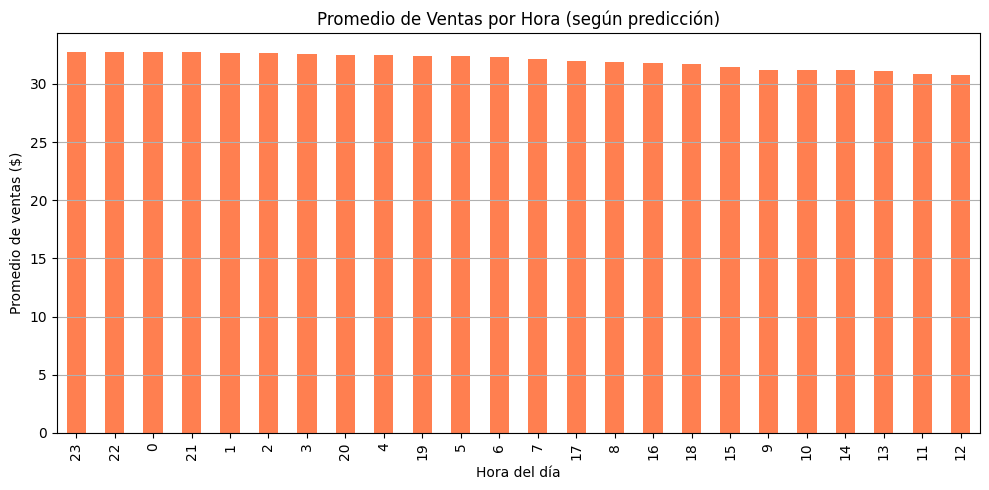

In [112]:
# Creamos un dataframe con fechas y predicciones.
predicted_df = pd.DataFrame({
    'datetime': fechas_test,
    'predicted_sales': predictions_inv.flatten()
})
predicted_df['hour'] = predicted_df['datetime'].dt.hour

# Agrupamos por hora para obtener el promedio de ventas predicho.
top_hours = predicted_df.groupby('hour')['predicted_sales'].mean().sort_values(ascending=False)

# Mostramos resultados.
print("🕒 Horarios con mayores ventas promedio (según predicción):")
print(top_hours)


# Visualizamos los horarios con mayores ventas.
plt.figure(figsize=(10,5))
top_hours.plot(kind='bar', color='coral')
plt.title('Promedio de Ventas por Hora (según predicción)')
plt.xlabel('Hora del día')
plt.ylabel('Promedio de ventas ($)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()
